## Identificação de leucemia em imagens

Este trabalho objetiva, através do uso de tecnicas de visão computacional e CNN, realizar a leitura e posterior identificação de leucócitos em imagens. <br><br>
As imagens utilizadas neste trabalho estão dispostas no arquivo [data](./data.zip) e cada uma esta nomeada seguindo o padrão `ImXXX_Y_Z.jpg`. `ImXXX` representa o número da imagem, `Y` o seu número da sequência de alteração e `Z` a sua classe (0 ou 1). A classe da imagem é o que designa se o paciente contém ou não contém leucemia, sendo 0 o indicativo de um paciente normal e 1 de portador de leucemia. <br><br>
Para realizar esta análise foram utilizadas duas principais bibliotecas, o `OpenCV` e o `SKLearn`. O `OpenCV` pode ser utilizado tanto durante a fase de processamento quanto treinamento de classificadores para identifcação de objetos, sendo que, neste trabalho, foi utilizao principalmente para tratamento das imagens. Ja o `SKLearn` é uma poderosa biblioteca para aplicação de aprendizado de máquina. Neste trabalho o `SKLearn` foi utilizado principalmente pelo uso do `Multi-layer Perceptron`, um algoritmo que trabalha com camadas escondidas de convoluções para extração de caracteristicas de imagens. <br><br>
Com a união dessas bibliotecas e alguns detalhes de implementação, foi possivel criar um classificador que realiza a identificação de leucócitos em imagens. <br><br>
Abaixo seguem detalhados os passos para o desenvolvimento e resultados obtidos com este trabalho.

### Desenvolvimento

Para iniciar o desenvolvimento, foram importadas as bibliotecas abaixo, sendo:
- *cv2*: OpenCV, utilizado para técnicas de visão computacional.
- *os*: módulo python que permite a iteração com o sistema operacional. Utilizado para leitura das imagens que serão utilizadas no treinamento e teste do classificador.
- *numpy*: prove alta performance para trabalhar com arrays multimencionais.
- *tqdm*: utilizada para exibir o progresso de execução de loops.
- *random*: utilizado para embaralhar os dados.
- *sklearn*: além do uso do algoritmo `MLPClassifier` que prove uma CNN para treinamento do classificador, também são importados o `train_test_split`, que realiza a divisão do conjunto de dados entre teste e treino e, também, o `metrics` que é utilizado para analisar os resultados obtidos pelo classificador.

In [1]:
import cv2 
import os 
import numpy as np 
from tqdm import tqdm
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

As imagens que serão utilizadas estão salvas localmente no diretório `~/data`, para isso é definida a variavel `folder` que recebe o local de armazenamento das imagens. Além disso, é criada a constante `IMG_SIZE` que sera utiliza mais tarde para setar as dimensões das imagens. <br><br>
Outra informação definida abaixo é o valor `random`. Isto é necessário para que a execução dos scripts que possuem dados randomicos resultem nos mesmos valores indiferentemente de por qual estação de trabalho seja executado.

In [2]:
folder = 'data'
IMG_SIZE = 50
np.random.seed(42)

Abaixo é definida a função `label_img`. Esta função recebe como parametro o nome de uma imagem (que como visto anteriormente, possui um padrão em sua nomenclatura que possui a informação da classe da imagem). Esta função tem o objetivo de verificar e retornar o valor da classe.

In [3]:
def label_img(img): 
    name = img.split('.')
    label = name[0].split('_')
    
    if label[2] == '0' : return 0
    else : return 1

O pré-processamento das imagens é realizado abaixo na função `create_data`. Aqui se define a variável `data`, que ira armazenar um array multidimencional contendo as informações das imagens. <br><br>
Para isso, primeiramente é realiza a leitura de cada imagem no diretório anteriomente definido. Ao ler uma imagem é chamada a função `label_img` para verificar sua classe e guardar o resultado em `label`. Com o auxilio do OpenCV é então realizada a leitura da imagem, feita a conversão para escala de cinza e redimencionada para o valor definido em `IMG_SIZE`. Além disso é aplicado filtro para definir as bordas da imagem. <br><br>
Realizado o tratamento, o array `data` adiciona em uma posição os dados pré-processados da imagem em formato `np.array` e sua classe. Para garantir a aleatoriadade, é utilizado o método `suffle` para realizar o embaralhamento dos dados dentro do array `data`. <br><br> Posteriormente, os dados contidos em 
`data` são salvos em um arquivo chamado [data.npy](./data.npy), este arquivo é utilizado para que em próximas execuções deste script não seja necessário refazer todo o processamento, bastando apenas carregar este arquivo em `data`.

In [4]:
data = []

def create_data():
    for img in tqdm(os.listdir(folder)): 
        label = label_img(img)
        path = os.path.join(folder, img) 

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        img = cv2.Canny(img,100,200)

        data.append([np.array(img), label])
    
    shuffle(data) 
    np.save('data.npy', data)

Como citado acima, caso ja tenhamos o arquivo [data.npy](./data.npy) não temos a necessidade de refazer o processamento de todas as imagens. Para isso foi implementada a lógica abaixo que verifica se este arquivo ja existe. Caso o arquivo exista, `data` recebe os dados do arquivo, caso contrário a função `create_data` é executada para processar as imagens.

In [5]:
if(os.path.exists('data.npy')): 
    data = np.load('data.npy', allow_pickle=True)
    data = data.tolist()
else: create_data()

Outro fator necessário é separar as imagens que serão utilizadas para treino e teste do classificador. Para isso, primeiramente são salvos em `X` os valores das imagens e em `y` suas classes. Após isso é feita uma transformação nas imagens para ficarem dimencionadas em um array unidimencional. <br><br>
Tendo os dados no formato necessário, é utilizado o `train_test_split` passando como parametro nosso conjunto de imagens, suas labels, o tamanho do conjuto de teste desejado (neste caso 0.33) e o valor randomico que deve ser aplicado). Assim, o algoritmo devolve quatro dados, sendo `X_train` os dados das imagens para treinamento e `y_train` suas respectivas classes e, `X_test` os dados das imagens para teste com `y_test` sendo suas respectivas classes.

In [6]:
X = np.array([i[0] for i in data])
y = [i[1] for i in data] 

nsamples, nx, ny = X.shape
dataset = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(
     dataset, y, test_size=0.33, random_state=42)

Abaixo é definido o classificador em `clf`. Foi definido o `solver` como `lbfgs` por desempenhar bem com conjuntos menores de dados, `max_iter` para limitar o número de iteração em 300 e setando o valor de `random` em 1. <br><br>
Criado o classificador, é realizado o treinamento utilizando o conjunto de dados separados no processo anterior e, em seguida, testado o classificador com o conjunto de teste para verificar o grau de acertividade do classificador. Neste caso, o score foi `0.779134295227525`

In [7]:
clf = MLPClassifier(solver='lbfgs', random_state=1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.779134295227525

Além do *score* de ~77% de acertividade, é possível analisar o modelo através da matrix de confusão resultante. De um total de 1802 imagens utilizados para o teste, 684 foram verdadeiros positivos, 214 verdadeiros negativos, 720 verdadeiros nagetivos e 184 falsos negativos.

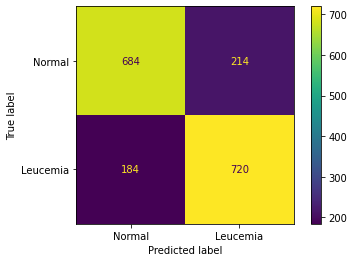

In [8]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Leucemia'])